# 1. Install Dependencies and Setup

In [1]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib cv2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


In [2]:
%pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
autopep8                     2.0.0
backcall                     0.2.0
beautifulsoup4               4.11.1
blinker                      1.6.2
bs4                          0.0.1
cachetools                   5.3.0
certifi                      2022.12.7
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
confusion-matrix             0.1
contourpy                    1.0.7
cycler                       0.11.0
dabl                         0.2.5
debugpy                      1.6.7
decorator                    5.1.1
dill                         0.3.6
dm-tree                      0.1.8
etils                        1.0.0
executing                    1.2.0
filelock                     3.12.0
Flask                        2.3.2
flatbuf

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

C:\Users\ADEBOSS\AppData\Local\Temp\ipykernel_9988\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'SKCD' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png', 'svg']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('SKCD')

Found 2357 files belonging to 9 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

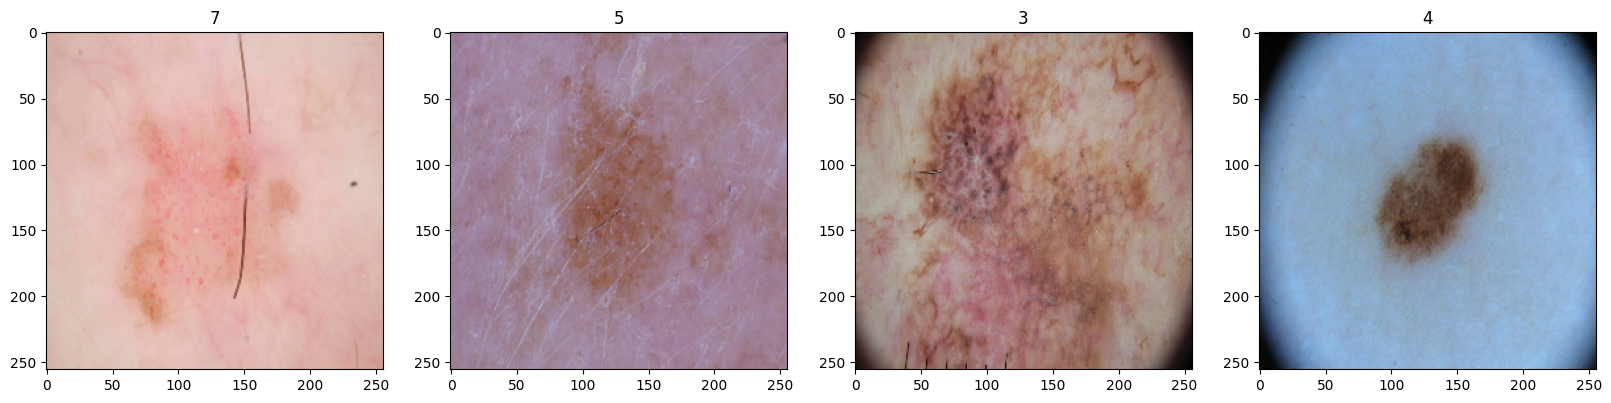

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.88039213, 0.77843136, 0.7745098 ],
          [0.9       , 0.8215686 , 0.80784315],
          [0.9098039 , 0.8352941 , 0.8156863 ],
          ...,
          [0.8745098 , 0.84313726, 0.80588233],
          [0.86470586, 0.8254902 , 0.79019606],
          [0.8686274 , 0.8235294 , 0.79019606]],
 
         [[0.88235295, 0.8       , 0.7882353 ],
          [0.9019608 , 0.83137256, 0.8156863 ],
          [0.9078431 , 0.8490196 , 0.8215686 ],
          ...,
          [0.86470586, 0.81960785, 0.7823529 ],
          [0.8627451 , 0.79607844, 0.75686276],
          [0.8568627 , 0.78431374, 0.7509804 ]],
 
         [[0.8882353 , 0.80588233, 0.7862745 ],
          [0.9098039 , 0.84705883, 0.81960785],
          [0.9019608 , 0.8509804 , 0.81960785],
          ...,
          [0.8490196 , 0.79607844, 0.7607843 ],
          [0.8490196 , 0.7745098 , 0.7372549 ],
          [0.8568627 , 0.77254903, 0.7470588 ]],
 
         ...,
 
         [[0.88235295, 0.8352941 , 0.8117647 ],
          [0.89411

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

51

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
51/51 [==============================] - 176s 3s/step - loss: -331180.0938 - accuracy: 0.1752 - val_loss: -2588534.2500 - val_accuracy: 0.1607
Epoch 2/20
51/51 [==============================] - 200s 4s/step - loss: -58103092.0000 - accuracy: 0.1661 - val_loss: -245239168.0000 - val_accuracy: 0.1629
Epoch 3/20
51/51 [==============================] - 202s 4s/step - loss: -1401532928.0000 - accuracy: 0.1661 - val_loss: -3929962752.0000 - val_accuracy: 0.1719
Epoch 4/20
51/51 [==============================] - 247s 5s/step - loss: -11846850560.0000 - accuracy: 0.1618 - val_loss: -26697799680.0000 - val_accuracy: 0.1339
Epoch 5/20
51/51 [==============================] - 261s 5s/step - loss: -56993599488.0000 - accuracy: 0.1703 - val_loss: -102238126080.0000 - val_accuracy: 0.1853
Epoch 6/20
51/51 [==============================] - 247s 5s/step - loss: -194437742592.0000 - accuracy: 0.1679 - val_loss: -313307332608.0000 - val_accuracy: 0.1741
Epoch 7/20
51/51 [=================

# 8. Plot Performance

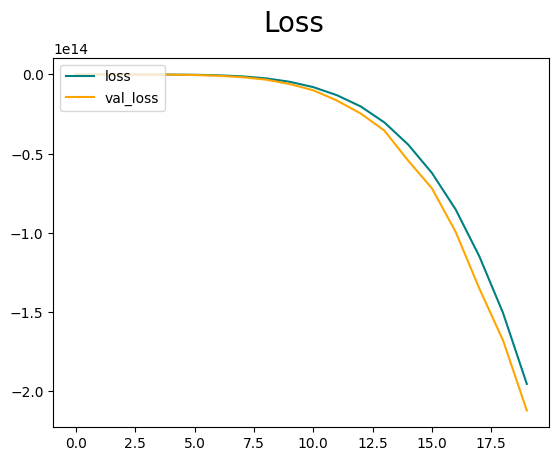

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

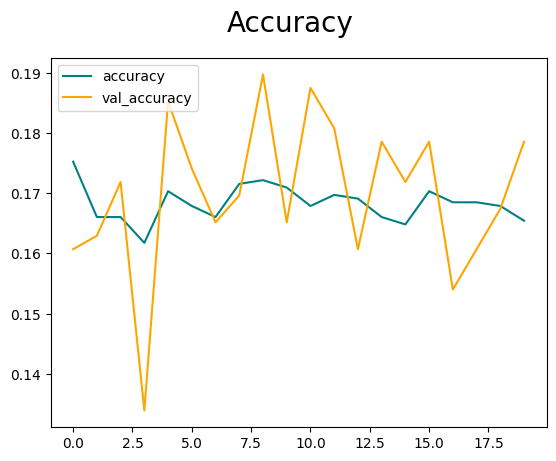

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 748ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9375, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.14285715, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

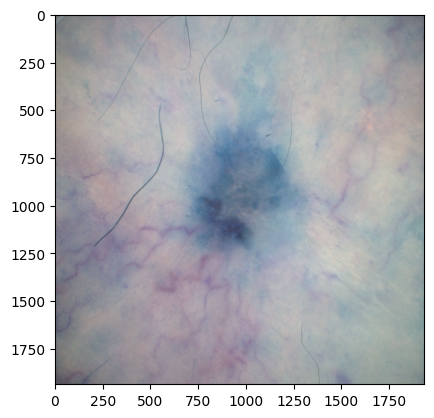

In [46]:
img = cv2.imread('SKCD/dermatofibroma/ISIC_0001114.jpg')
plt.imshow(img)
plt.show()

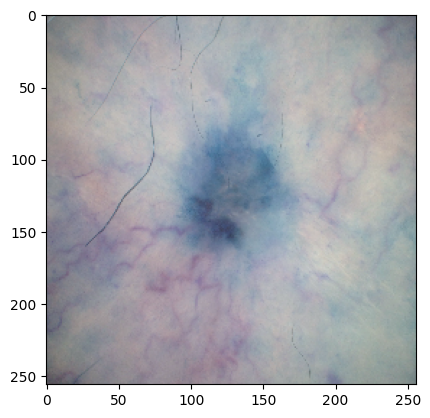

In [47]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 1s 560ms/step


In [49]:
yhat

array([[1.]], dtype=float32)

In [40]:
print(yhat)

[[1.]]


In [50]:
if yhat < 0.5: 
    print(f'Predicted class is actinic keratosis')
elif 0.5 < yhat < 1.5:
    print(f'Predicted class is basal cell carcinoma')
elif 1.5 < yhat < 2.5: 
    print(f'Predicted class is dermatofibroma')
elif 2.5 < yhat < 3.5:
    print(f'Predicted class is melanoma')
elif 3.5 < yhat < 4.5: 
    print(f'Predicted class is nevus')
elif 4.5 < yhat < 5.5:
    print(f'Predicted class is pigmented benign keratosis')
elif 5.5 < yhat < 6.5: 
    print(f'Predicted class is seborrheic keratosis')
elif 6.5 < yhat < 7.5:
    print(f'Predicted class is squamous cell carcinoma')
elif 7.5 < yhat < 8.5:
    print(f'Predicted class is vascular lesion')
else:
    print(f'no referrence ')

Predicted class is basal cell carcinoma


# 11. Save the Model

In [42]:
from tensorflow.keras.models import load_model

In [43]:
model.save(os.path.join('models','imageclassifier.h5'))

In [44]:
new_model = load_model('models/imageclassifier.h5')

In [45]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 175ms/step


array([[1.]], dtype=float32)